Import dependencies

In [1]:
from typing import List, Optional, Tuple, Dict, Any, Union, Callable
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.functional import softmax

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from transformers import AutoImageProcessor
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

from PIL import Image, ImageOps, UnidentifiedImageError
from pillow_heif import register_heif_opener
register_heif_opener()

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

c:\Users\MZywi\Documents\Uni\MSc2\msp\msp_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Choose model

In [2]:
all_stations = True

In [3]:
# mount = '/content/drive/MyDrive/Uni Stuttgart/AACV/data'
mount = '..'

if all_stations:
    station_names = ['Hauptbahnhof','Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']
    station_ids = [0, 1, 2, 3, 4]
    names_to_ids = {'Hauptbahnhof':0,'Stadtmitte':1, 'Feuersee':2, 'Schwabstrasse':3, 'University':4}
    ids_to_names = {0:'Hauptbahnhof', 1:'Stadtmitte', 2:'Feuersee', 3:'Schwabstrasse', 4:'University'}
else:
    station_names = ['Hauptbahnhof','Stadtmitte', 'Feuersee', 'Schwabstrasse']
    station_ids = [0, 1, 2, 3]
    names_to_ids = {'Stadtmitte':0, 'Feuersee':1, 'Schwabstrasse':2, 'University':3}
    ids_to_names = {0:'Stadtmitte', 1:'Feuersee', 2:'Schwabstrasse', 3:'University'}

In [4]:
df = []
data_dir = f'{mount}/data'

for name in os.listdir(data_dir):
  for file_type in os.listdir(f'{data_dir}/{name}'):
    for station in station_names:
        try:
            for st_name_vis in os.listdir(f'{data_dir}/{name}/{file_type}/{station}'):
              for f in os.listdir(f'{data_dir}/{name}/{file_type}/{station}/{st_name_vis}'):
                  df.append((station, name, file_type, st_name_vis, f, f'{name}/{file_type}/{station}/{st_name_vis}/{f}'))
        except FileNotFoundError:
            pass
    

df = pd.DataFrame(df, columns=['station', 'author', 'file_type', 'st_name_visible', 'filename', 'file_path'])

# ensures correct order of appearance in plots
df['station'] = pd.Categorical(df['station'], ordered=True,
                categories=['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University'])

df['st_name_visible'] = df['st_name_visible'].replace({'st_name': True, 'no_st_name': False})
df['st_name_visible'] = pd.Categorical(df['st_name_visible'], ordered=True, categories=[True, False])
# df = df[df['st_name_visible'] == True]
df


station  author file_type st_name_visible             filename  \
0    Stadtmitte    Anna       raw           False  20250506_111039.jpg   
1    Stadtmitte    Anna       raw           False  20250506_111040.jpg   
2    Stadtmitte    Anna       raw           False  20250508_133816.jpg   
3    Stadtmitte    Anna       raw           False     st_no_name_1.png   
4    Stadtmitte    Anna       raw            True  20250506_111028.jpg   
..          ...     ...       ...             ...                  ...   
202  University  Berkay       raw           False        IMG_6733.HEIC   
203  University  Berkay       raw            True        IMG_6583.HEIC   
204  University  Berkay       raw            True        IMG_6729.HEIC   
205  University  Berkay       raw            True        IMG_6731.HEIC   
206  University  Berkay       raw            True        IMG_6734.HEIC   

                                             file_path  
0    Anna/raw/Stadtmitte/no_st_name/20250506_111039...  
1    Anna/raw/Stadtmitte/no_st_name/20250506_111040...  
2    Anna/raw/Stadtmitte/no_st_name/20250508_133816...  
3      Anna/raw/Stadtmitte/no_st_name/st_no_name_1.png  
4      Anna/raw/Stadtmitte/st_name/20250506_111028.jpg  
..                                                 ...  
202     Berkay/raw/University/no_st_name/IMG_6733.HEIC  
203        Berkay/raw/University/st_name/IMG_6583.HEIC  
204        Berkay/raw/University/st_name/IMG_6729.HEIC  
205        Berkay/raw/University/st_name/IMG_6731.HEIC  
206        Berkay/raw/University/st_name/IMG_6734.HEIC  

[207 rows x 6 columns]

In [5]:
# load premade dataset
df = []
if all_stations:
    data_dir = f'{mount}/dataset/dataset_5'
else:
    data_dir = f'{mount}/dataset/dataset_4'

df_train = pd.read_csv(f'{data_dir}/train/df_train.csv')
df_dev = pd.read_csv(f'{data_dir}/val/df_val.csv')
df_test = pd.read_csv(f'{data_dir}/test/df_test.csv')
df_test_masked = pd.read_csv(f'{data_dir}/test_st_name/st_name_masked/df_test_st_name_masked.csv')
df_test_visible = pd.read_csv(f'{data_dir}/test_st_name/st_name_visible/df_test_st_name_visible.csv')


In [6]:
# df['station'].hist()

## Dataset and dataloader

In [7]:
# switch model here: ViT = ViTForImageClassification
model_name = "ViT"
run_ID = 17  # to identify the results later

# code from https://huggingface.co/docs/transformers/en/tasks/image_classification
checkpoint = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

def process(image):
    checkpoint = "google/vit-base-patch16-224"
    image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast = True)

    normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    size = (
        image_processor.size["shortest_edge"]
        if "shortest_edge" in image_processor.size
        else (image_processor.size["height"], image_processor.size["width"])
    )
    _transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])
    return _transforms(image.convert("RGB"))


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [8]:
class ImageDataset(Dataset):

    def __init__(self, data_dir, df, transform=None):
        self.data_dir = data_dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, ind):
        item_metadata = self.df.iloc[ind].to_dict()
        label = torch.tensor(names_to_ids[item_metadata['station']])

        image_filepath = f"{self.data_dir}/{item_metadata['file_path']}"
        image = Image.open(image_filepath)
        if self.transform:
          image = self.transform(image)
        return image, label

Set random seed values for reproducibility

In [9]:
seed_val = 42  # 42, 17, 6

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Time formatting function

In [10]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Introduce GPU

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
batch_size = 32 if device == 'cuda' else 16

# df_train, df_test = train_test_split(df, test_size=0.33)

train_dataset = ImageDataset(data_dir=data_dir, df=df_train, transform=process)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

dev_dataset = ImageDataset(data_dir=data_dir, df=df_dev, transform=process)
dev_dataloader = DataLoader(dev_dataset, batch_size=1)

test_dataset = ImageDataset(data_dir=data_dir, df=df_test, transform=process)
test_dataloader = DataLoader(test_dataset, batch_size=1)

test_masked_dataset = ImageDataset(data_dir=data_dir, df=df_test_masked, transform=process)
test_masked_dataloader = DataLoader(test_masked_dataset, batch_size=1)

test_visible_dataset = ImageDataset(data_dir=data_dir, df=df_test_visible, transform=process)
test_visible_dataloader = DataLoader(test_visible_dataset, batch_size=1)


In [13]:
len(train_dataset), len(train_dataloader)

(151, 10)

In [14]:
len(test_dataset), len(test_dataloader)

(43, 43)

## Model

In [15]:
match model_name:
    case "ViT":
        from transformers import ViTForImageClassification
        model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", 
                                                          num_labels=len(station_names),
                                                          ignore_mismatched_sizes=True,
                                                          attn_implementation="eager")
    case _:
        from transformers import ViTForImageClassification
        model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=len(station_names))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [17]:
model.num_labels

5

In [18]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

Initialize `AdamW` optimizer and learning rate scheduler. We are going to train for 3 epochs

In [19]:
lr = 3e-4
optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = 1e-8  # default
                )

In [20]:
epochs = 3

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Training

And now we are ready to train. We are going to run validation on the dev set after every epoch and gather the statistics.

## Training loop

In [142]:
training_stats = []
total_t0 = time.time()
validate = True

validation_dataloader = dev_dataloader

for epoch_i in range(0, epochs):
    # training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        model.zero_grad()
        output = model(pixel_values, labels = labels, output_attentions=True)
        loss, logits = output.loss, output.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        del batch

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # validation
    if validate:
        print("")
        print("Validation...")

        t0 = time.time()
        model.eval()
        total_eval_acc = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        val_predictions = []
        val_labels = []

        for batch in validation_dataloader:
            pixel_values = batch[0].to(device)
            labels = batch[1].to(device)

            with torch.no_grad():
                output = model(pixel_values, labels = labels)
            loss, logits = output.loss, output.logits
            total_eval_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            predictions = np.argmax(logits, axis=1).flatten()
            labels = labels.to('cpu').numpy()

            total_eval_acc += accuracy_score(labels, predictions, normalize=True)
            val_predictions.append(predictions)
            val_labels.append(labels)
            del batch

        # Report the final accuracy for this validation run.
        avg_val_acc = total_eval_acc / len(validation_dataloader)
        print("  Avr Acc: {0:.2f}".format(avg_val_acc))

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

    if validate:
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Macro Acc.': avg_val_acc,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    else:
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Time': training_time,
            }
        )

total_val_f1 = f1_score(val_labels, val_predictions, average='macro')
print("")
print("Training complete!")
print("  Validation F1: {0:.2f}".format(total_val_f1))

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...

  Average training loss: 1.07
  Training epoch took: 0:01:48

Validation...
  Avr Acc: 0.68
  Validation Loss: 0.77
  Validation took: 0:00:11

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.24
  Training epoch took: 0:01:30

Validation...
  Avr Acc: 0.91
  Validation Loss: 0.26
  Validation took: 0:00:14

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.09
  Training epoch took: 0:01:37

Validation...
  Avr Acc: 1.00
  Validation Loss: 0.04
  Validation took: 0:00:14

Training complete!
  Validation F1: 1.00
Total training took 0:05:34 (h:mm:ss)


## Training stats

Let's see how the training panned out. The plot shows the average training and validation losses of a given epoch against the epoch number. In this case, we can see that the model went into overfitting after epoch 2.

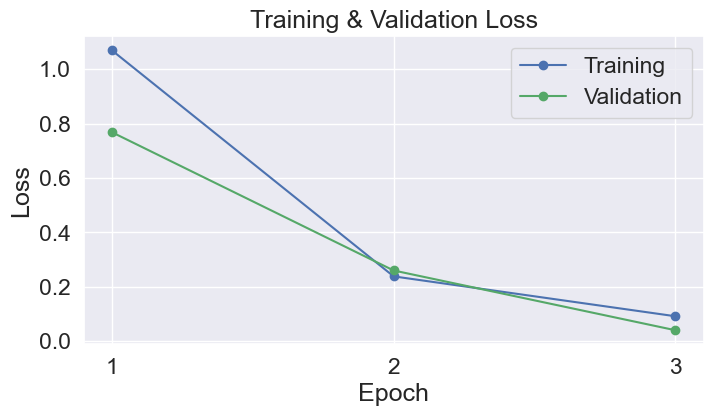

In [143]:
training_stats = pd.DataFrame(data=training_stats)

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,4)

plt.plot(training_stats['epoch'], training_stats['Training Loss'], 'b-o', label="Training")
if validate == True:
    plt.plot(training_stats['epoch'], training_stats['Valid. Loss'], 'g-o', label="Validation")

    plt.title("Training & Validation Loss")
else:
    plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1, epochs + 1))

plt.show()

## Save the model

In [21]:
os.makedirs(f'{mount}/models/{model_name}', exist_ok=True)
base_filename = f"{model_name}_{run_ID}_ep{epochs}_"
base_filename += f"seed{seed_val}_"
base_filename += f"lr{lr:.1e}"
base_filename += "_ds5"
print(base_filename)

ViT_17_ep3_seed42_lr3.0e-04_ds5


In [145]:
filename = f'{mount}/models/{model_name}/{base_filename}.pt'
print(filename)
torch.save(model, filename)

../models/ViT/ViT_17_ep3_seed42_lr3.0e-04_ds5.pt


In [22]:
# load model from checkpoint
base_filename = base_filename # 'ViT_11_ep3_seed17_lr3.0e-04' # 'ViT_6_ep3_seed17_lr2.5e-04'
model = torch.load(f'{mount}/models/{model_name}/{base_filename}.pt')

# Testing

Run the model on the test set for an final independent evaluation

In [23]:
seed_val = seed_val
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [24]:
test_set_predictions, test_set_proba, test_set_labels = [], [], []
test_logits, test_attentions, batches_test_attentions = [], [], []
total_eval_acc = 0
total_eval_f1 = 0
model.eval()

t_dataloader = test_dataloader
df_t = df_test

for batch in tqdm(t_dataloader):
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            output = model(pixel_values,
                          labels=labels,
                          output_attentions=True)
        loss, logits = output.loss, output.logits
        out_att = output.attentions
        test_logits.append(logits)
        test_attentions = out_att
        batches_test_attentions.append(test_attentions)

        pred_proba = softmax(logits, dim=-1).detach().cpu().numpy()  # pred class probabilities
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten()   # pred class labels
        test_set_predictions.append(predictions)
        test_set_proba.append(pred_proba)
        labels = labels.to('cpu').numpy()
        test_set_labels.append(labels)
        total_eval_acc += accuracy_score(labels, predictions, normalize=True)

        del batch

test_set_predictions = np.concatenate(test_set_predictions, axis=0)
test_set_proba = np.concatenate(test_set_proba, axis=0)

avg_val_acc = total_eval_acc / len(t_dataloader)
test_f1 = f1_score(test_set_labels, test_set_predictions, average='macro')
print("  Avr Acc: {0:.3f}".format(avg_val_acc))
print("  Test F1: {0:.3f}".format(test_f1))
# print(out_att)

100%|██████████| 43/43 [00:39<00:00,  1.09it/s]

  Avr Acc: 0.977
  Test F1: 0.976


In [25]:
misclassifications = []
true_classifications = []
y_true = [names_to_ids[x] for x in df_t['station'].to_list()]
y_filenames = [x for x in df_t['file_path'].to_list()]

for i in range(len(test_set_predictions)):
    if test_set_predictions[i] != y_true[i]:
        print(f'predicted: {ids_to_names[test_set_predictions[i]]}, true: {ids_to_names[y_true[i]]}')
        print(y_filenames[i])
        misclassifications.append((test_set_predictions[i], y_true[i], y_filenames[i], i))
    else:
        true_classifications.append((test_set_predictions[i], y_true[i], y_filenames[i], i))

predicted: Schwabstrasse, true: Feuersee
test/images/20250502_113823.jpg


# Plots & Statistics

## Heatmap

In [26]:
# normalize='true' -- normalize along rows
norm_setting = 'true'

y_true = [names_to_ids[x] for x in df_t['station'].to_list()]
test_conf_matr = confusion_matrix(y_true, test_set_predictions,
                                 normalize=norm_setting)
test_conf_matr = pd.DataFrame(test_conf_matr, columns=station_names,
                             index=station_names)

Text(0.5, 20.049999999999997, 'Predicted')

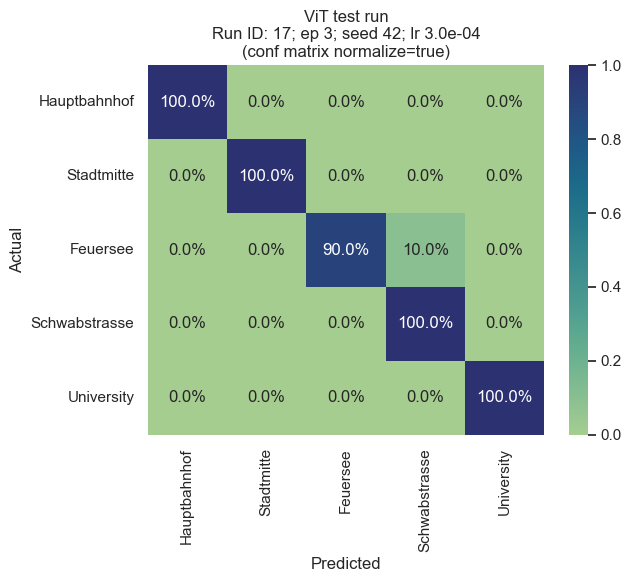

In [27]:
sns.heatmap(test_conf_matr, cmap='crest', annot=True, fmt=".1%")
plt.title(f"""{model_name} test run
Run ID: {run_ID}; ep {epochs}; seed {seed_val}; lr {lr:.1e}
(conf matrix normalize={norm_setting})""")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Attention Maps
code from https://github.com/jeonsworld/ViT-pytorch.git

In [28]:
import cv2

device = 'cuda'

In [29]:
for mis in misclassifications:
    print(f'predicted: {mis[0]}, true: {mis[1]}, path: {mis[2]}')

predicted: 3, true: 2, path: test/images/20250502_113823.jpg


In [30]:
for t in true_classifications:
    print(f'predicted: {t[0]}, true: {t[1]}, path: {t[2]}')

predicted: 0, true: 0, path: test/images/IMG_6867.HEIC
predicted: 0, true: 0, path: test/images/5ebb528e-7525-4ec2-96fe-53a426c7f50f.jpg
predicted: 1, true: 1, path: test/images/IMG_6576.HEIC
predicted: 0, true: 0, path: test/images/1468dd07-54f5-4e5f-8830-1a7aca5ba146.jpg
predicted: 3, true: 3, path: test/images/20250506_111516.jpg
predicted: 3, true: 3, path: test/images/20250417_111137.jpg
predicted: 1, true: 1, path: test/images/IMG_6574.HEIC
predicted: 2, true: 2, path: test/images/20250502_131400.jpg
predicted: 1, true: 1, path: test/images/IMG_6696.HEIC
predicted: 0, true: 0, path: test/images/IMG_6865.HEIC
predicted: 2, true: 2, path: test/images/20250502_113839.jpg
predicted: 0, true: 0, path: test/images/6ca14863-e57e-4443-b6a4-6c402768f064.jpg
predicted: 2, true: 2, path: test/images/20250424_121504.jpg
predicted: 4, true: 4, path: test/images/20250512_130906.jpg
predicted: 4, true: 4, path: test/images/20250519_135514.jpg
predicted: 1, true: 1, path: test/images/20250513_13

In [66]:
# use prediction from test run

all_logits = [l for l in test_logits]

# pred_label, true_label, f_path, index = misclassifications[0]
pred_label, true_label, f_path, index = true_classifications[7]

image = Image.open(f'{data_dir}/{f_path}')
x = process(image)
x = x.to(device)

logits = all_logits[index]
att_mat = batches_test_attentions[index]

In [67]:
device = 'cpu'
logits = logits.to(device)

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)
att_mat = att_mat.to(device)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1), device=torch.device(device))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size(), device=torch.device(device))
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
v = v.to('cpu')
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
result = cv2.resize(mask / mask.max(), image.size)
#mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
#result = (mask * image).astype("uint8")

Prediction Label and Attention Map
test/images/20250502_131400.jpg

0.98936 : Feuersee 
0.00631 : Schwabstrasse 
0.00305 : Stadtmitte 


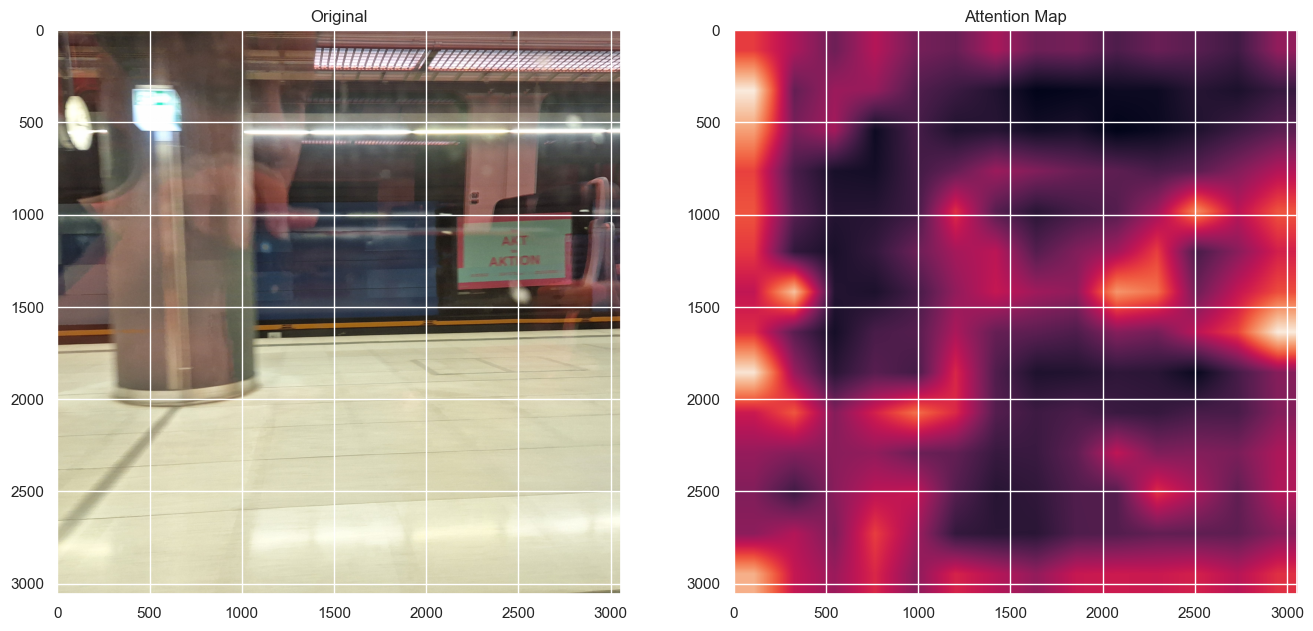

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print(f"Prediction Label and Attention Map\n{f_path}\n")
for idx in top5[0, :3]:
    print(f'{probs[0, idx.item()]:.5f} : {station_names[idx.item()]} \n', end='')

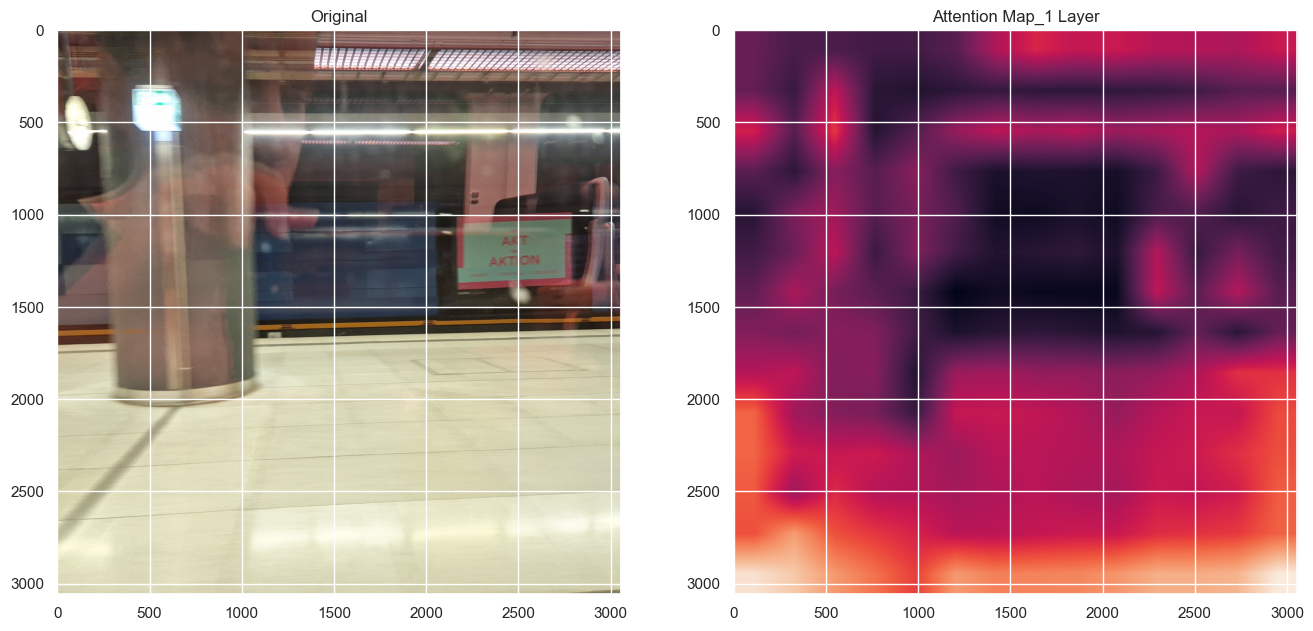

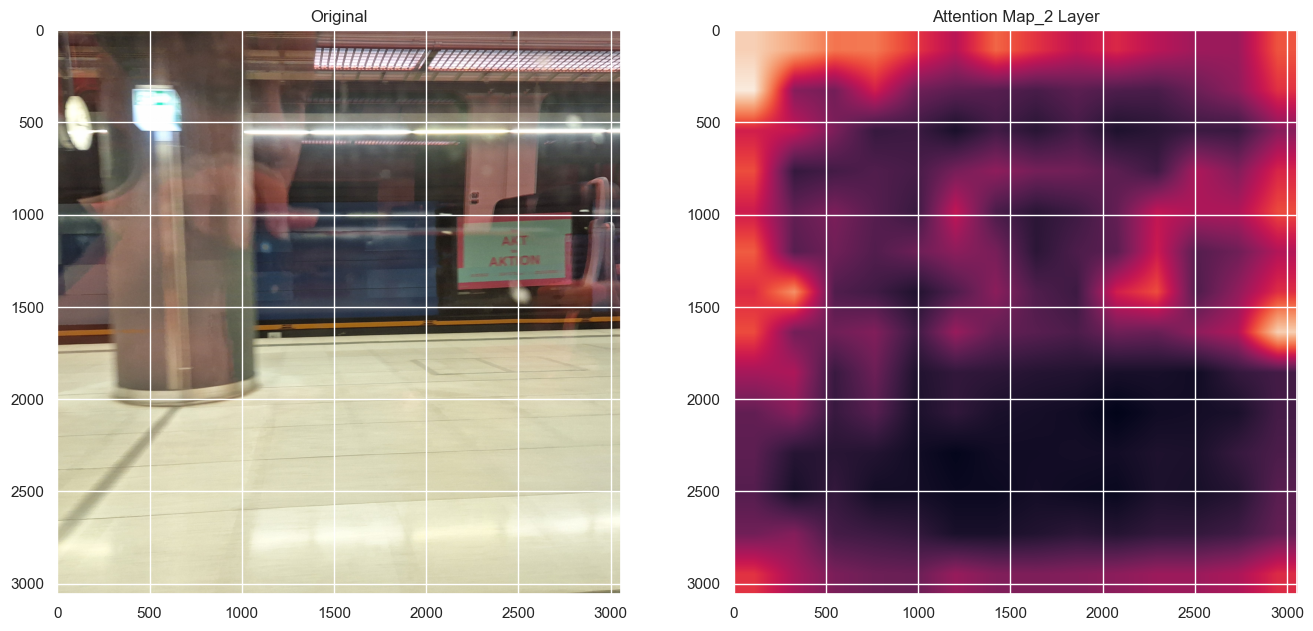

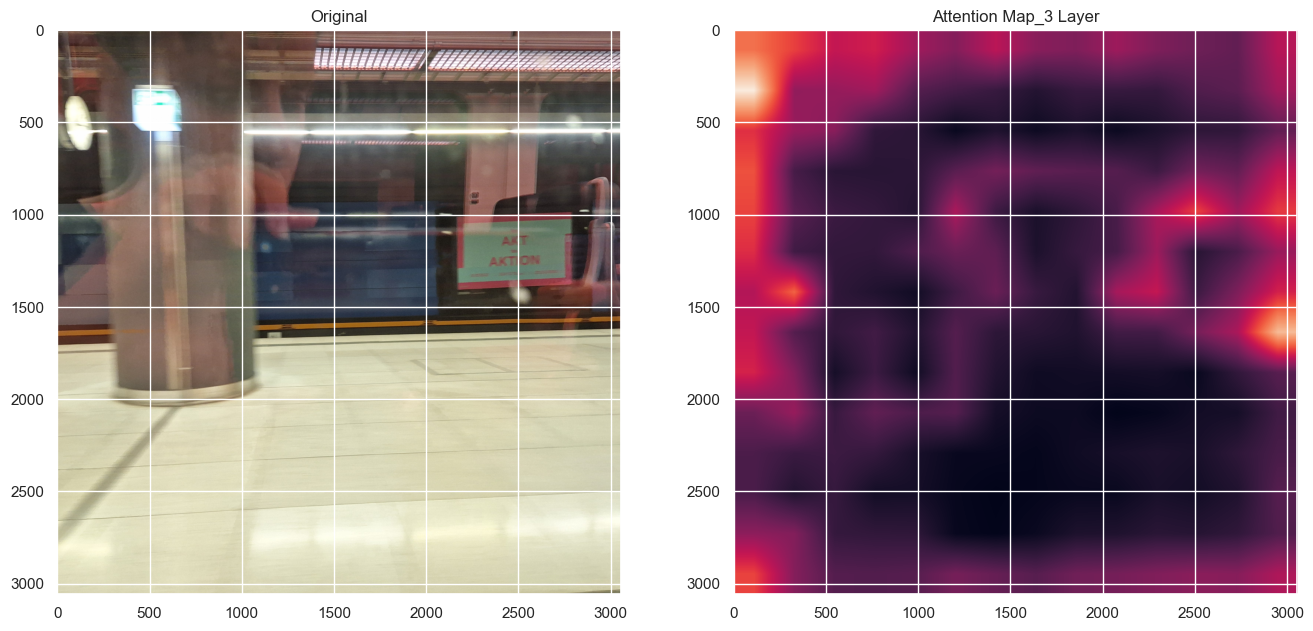

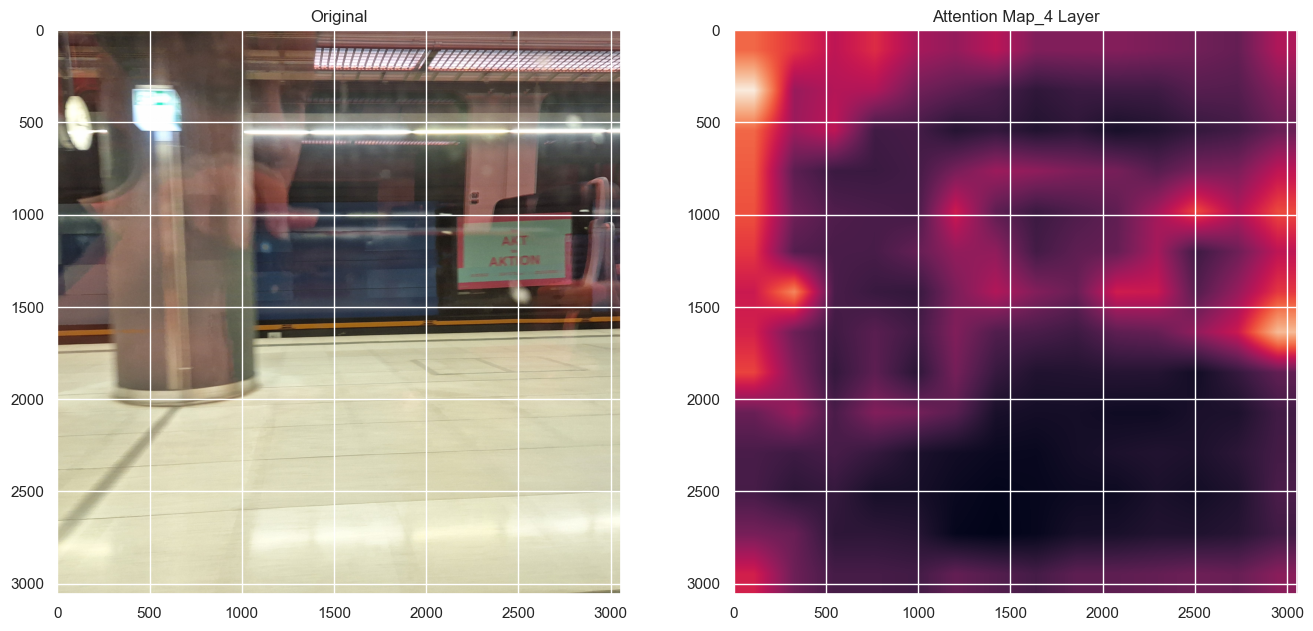

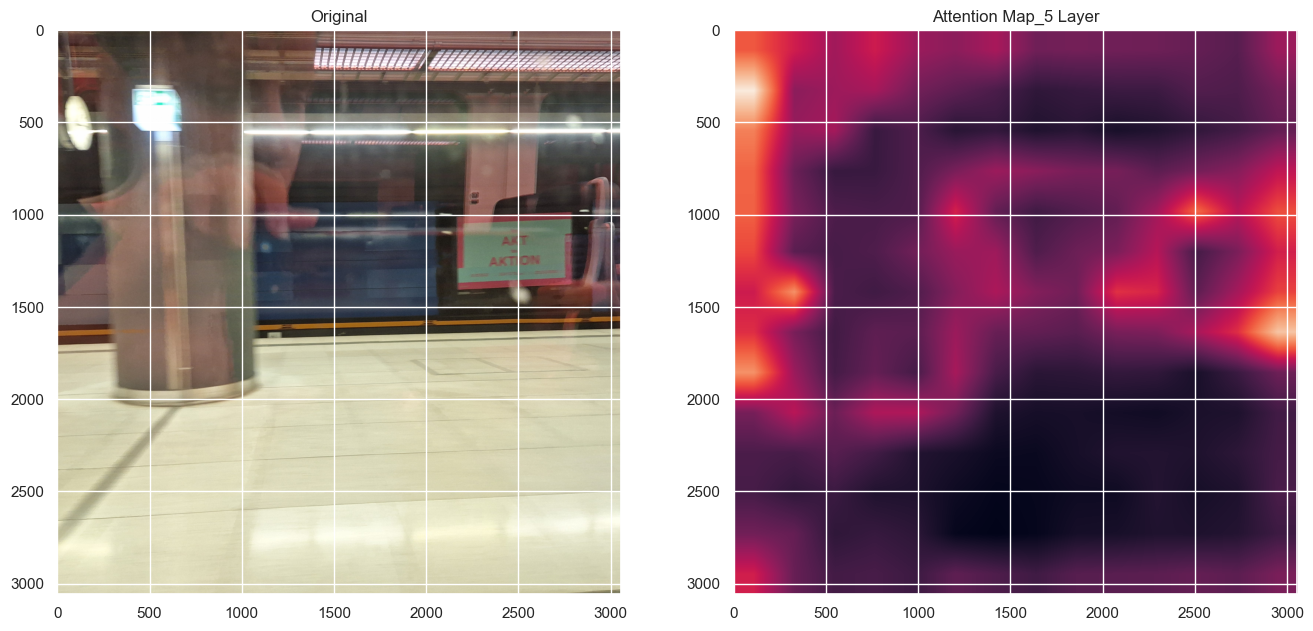

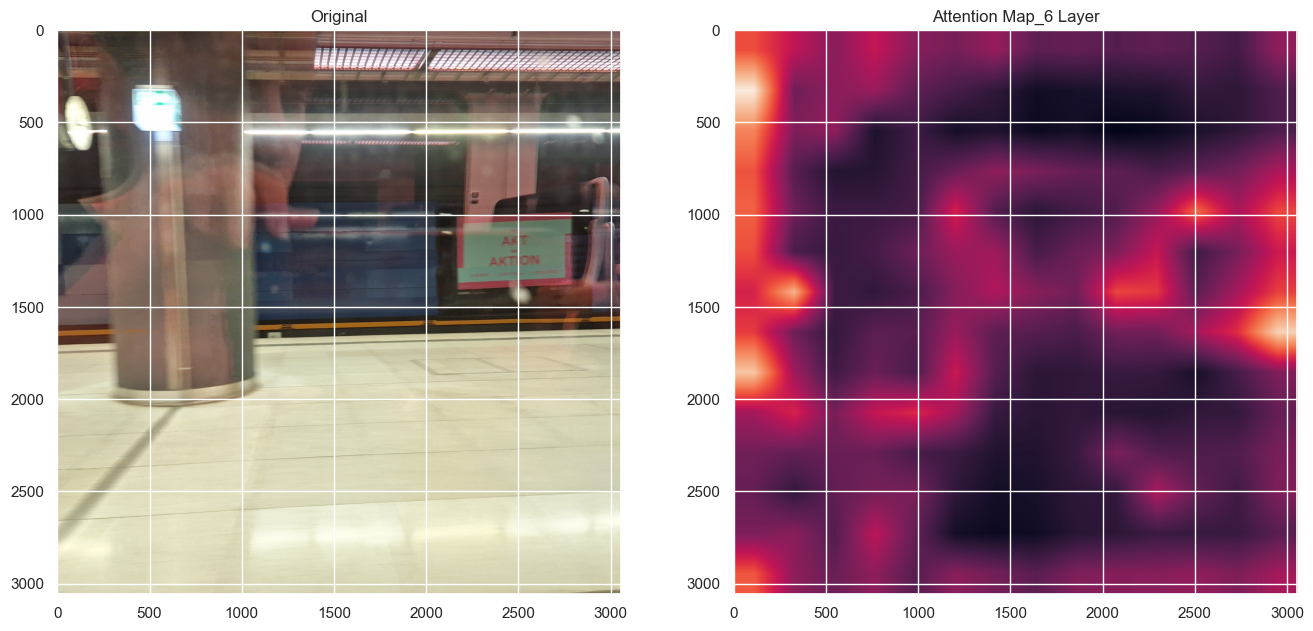

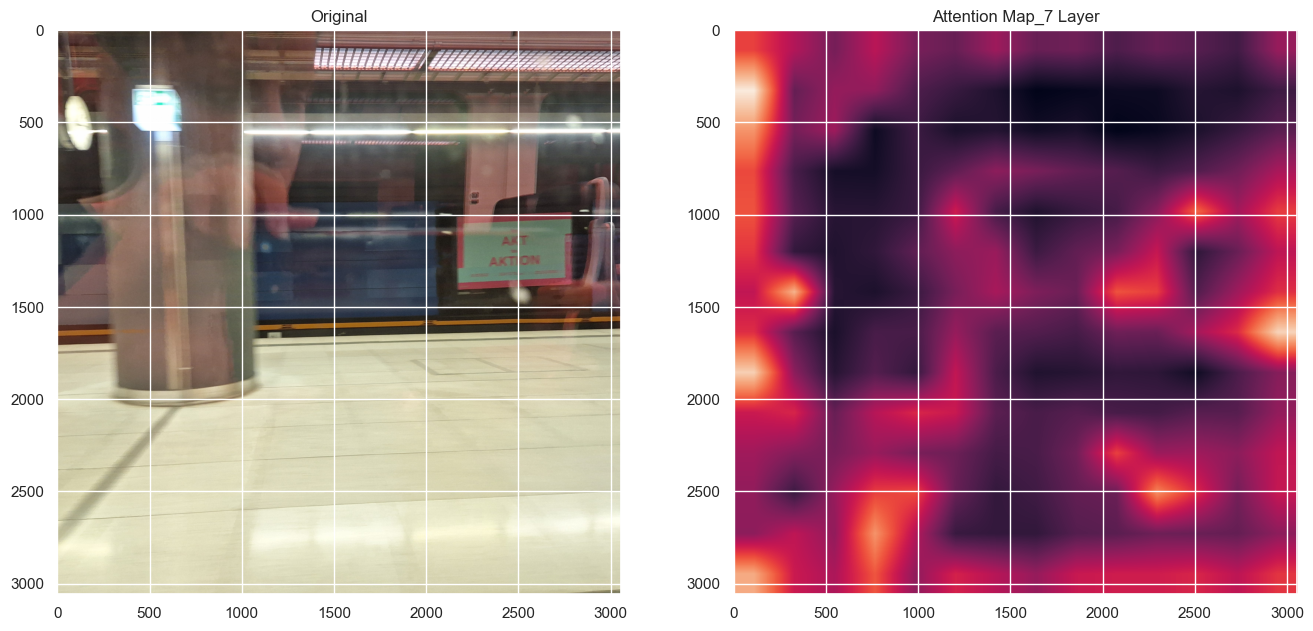

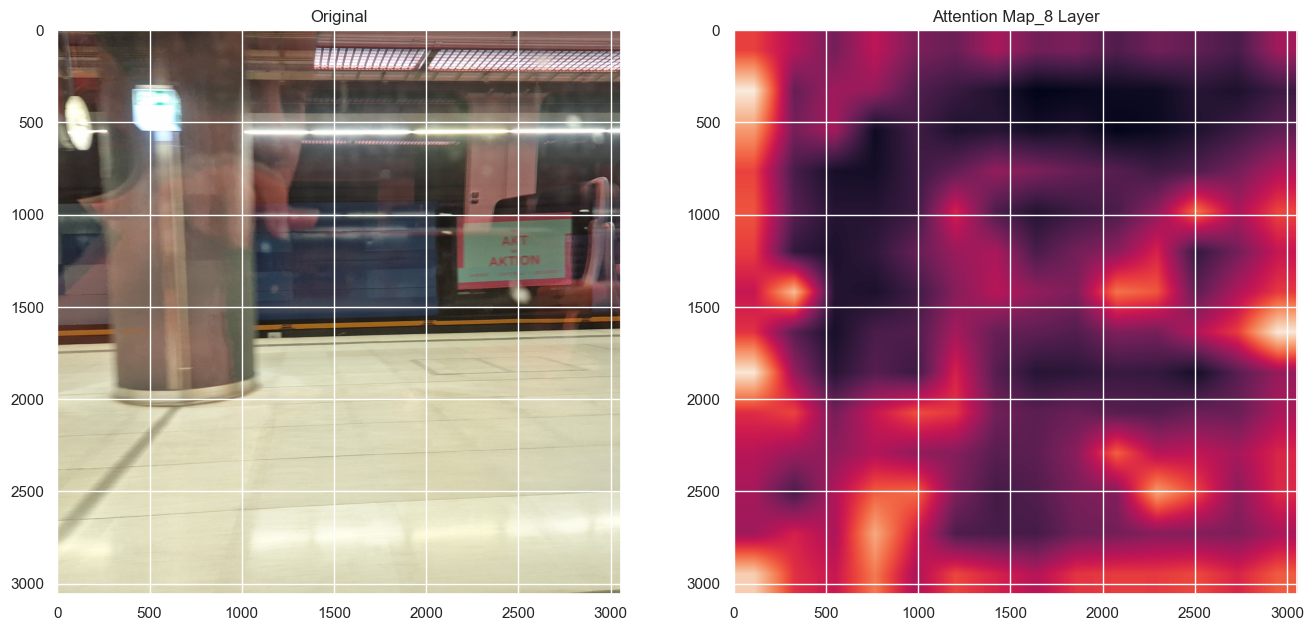

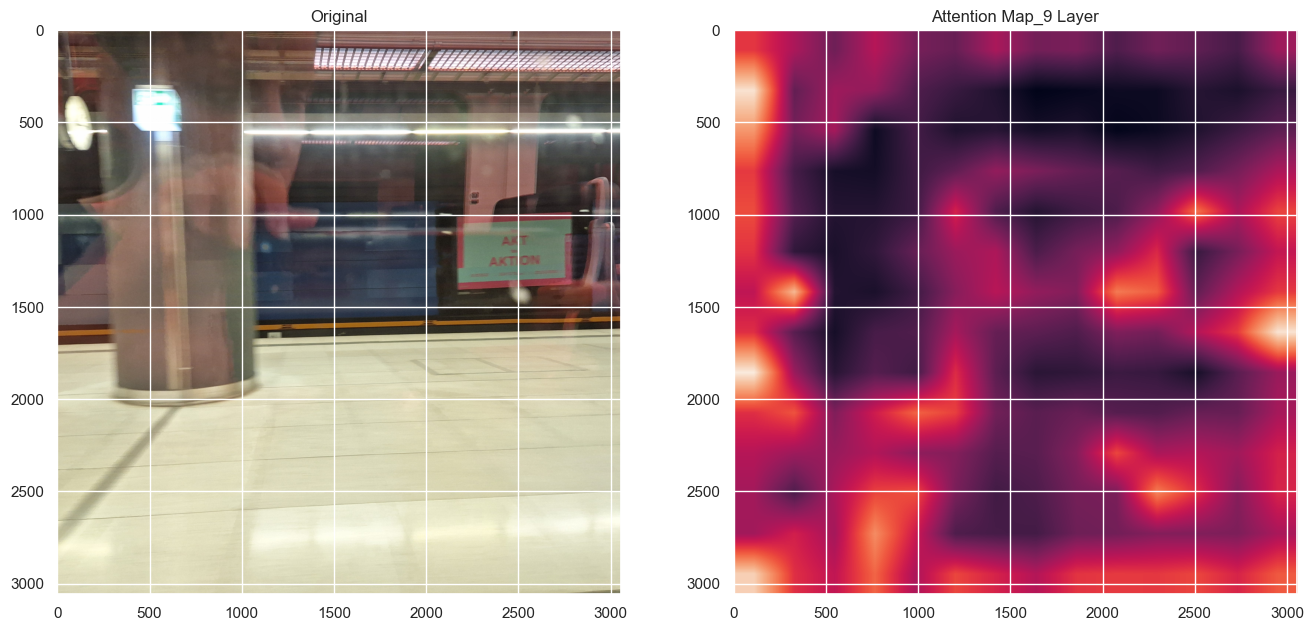

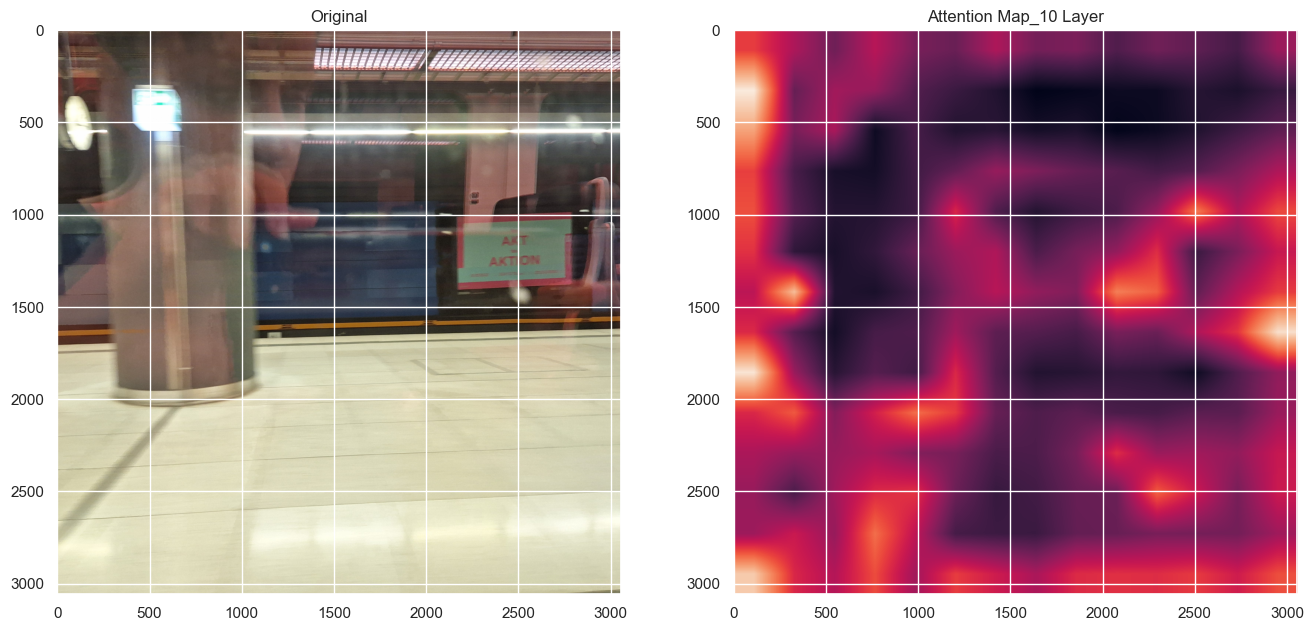

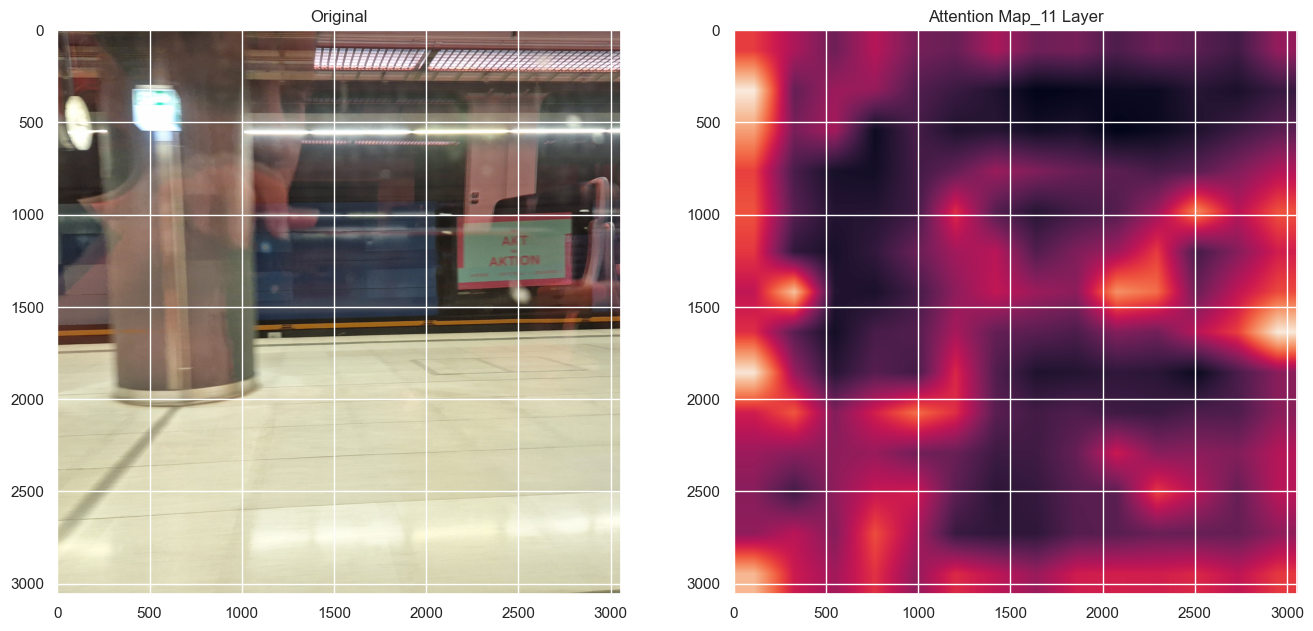

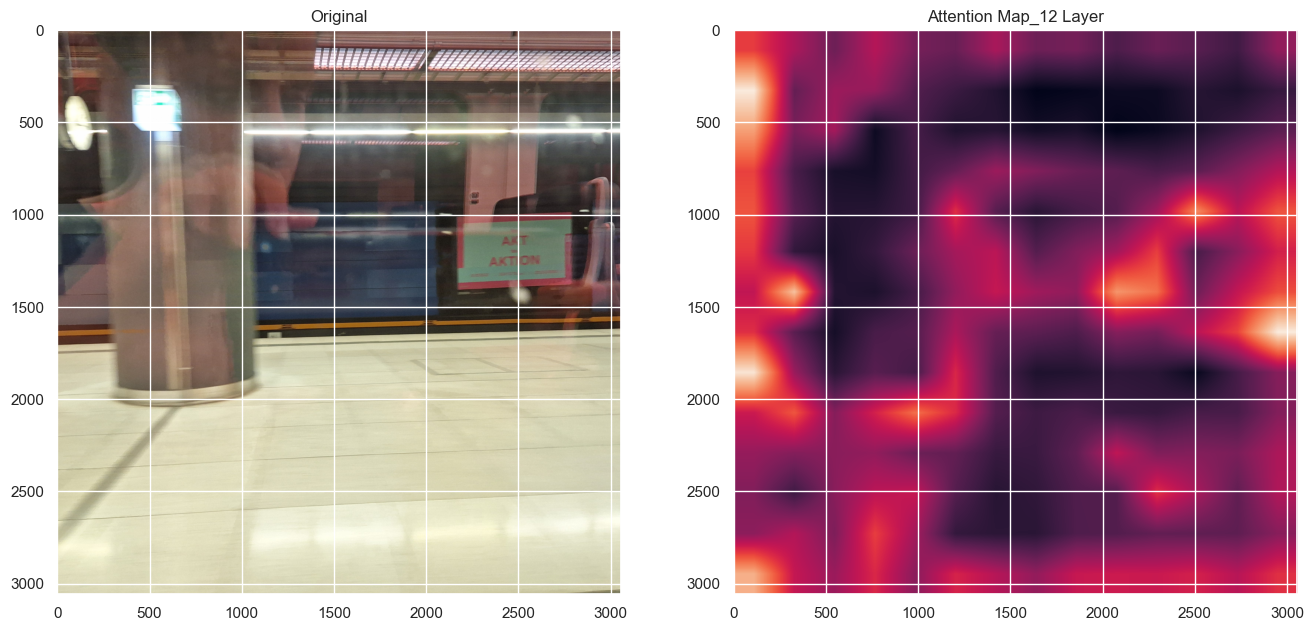

In [69]:

for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    result = cv2.resize(mask / mask.max(), image.size)
    #mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    #result = (mask * image).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(image)
    _ = ax2.imshow(result)